In [1]:
import os,re,sys,pickle,datetime,time,random,itertools
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import openpyxl
from openpyxl import load_workbook
import pandas as pd
import math
import seaborn as sns 
import umap
import umap.plot
from PIL import Image
from sklearn.cluster import KMeans
from sklearn import metrics
from sklearn.multioutput import MultiOutputRegressor
from sklearn.neighbors import KNeighborsClassifier, NearestNeighbors
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler,MinMaxScaler,PolynomialFeatures
from sklearn.decomposition import PCA
import hdbscan
import sklearn.cluster as cluster
from sklearn.metrics import adjusted_rand_score, adjusted_mutual_info_score
randomstate = 42
import rdkit
from rdkit import Chem
from rdkit.Chem import AllChem, MolFromSmiles, PandasTools, Descriptors, Draw, PropertyMol, rdmolfiles, rdFMCS
from rdkit import RDConfig
from rdkit.Chem.rdmolops import RemoveHs
from rdkit.ML.Descriptors import MoleculeDescriptors
from rdkit.Chem.Draw import MolsToGridImage, IPythonConsole, rdMolDraw2D
from rdkit.Chem.Draw.MolDrawing import MolDrawing,DrawingOptions, Font
DrawingOptions.bondLineWidth=1.8
size = (150, 150)
import plotly.express as px
import molplotly # requires dash version 2.0 (latest = 2.1); use pip list and pip install dash==2.0
import mols2grid
from tdc.single_pred import ADME
import useful_rdkit_utils as uru
from tqdm import tqdm
from IPython.display import SVG

def get_matching_atoms(mol_in, smarts):
    pat = Chem.MolFromSmarts(smarts)
    return [x[0] for x in mol_in.GetSubstructMatches(pat)]

def mol_with_atom_index(mol):
    for atom in mol.GetAtoms():
        atom.SetAtomMapNum(atom.GetIdx())
    return mol

from crem.crem import mutate_mol, grow_mol, link_mols
crem_db_file = '/Users/cian/Desktop/code/crem/replacements02_sc2.5.db'

# Introduction

CReM is an mmpa-based method to generate chemically reasonable analogs of a starting structure.

CReM uses database files available from http://www.qsar4u.com/pages/crem.php. Currently using replacements02_sc2.5.db, can use replacements02_sc2.db for more synthetically accessible structures. replacements02_sc2.5.db was created using ChEMBL v22 structures containing only C,N,O,S,P,F,Cl,Br,I that maximum synthetic complexity score (SCScore) of 2.5.

Function arguments: https://crem.readthedocs.io/en/latest/operations.html

*References*

https://github.com/DrrDom/crem

https://jcheminf.biomedcentral.com/articles/10.1186/s13321-020-00431-w

https://pubs.acs.org/doi/10.1021/acs.jcim.0c00792

Example adapted from: https://github.com/czodrowskilab/5minfame/blob/main/2022_02_25-Hazemann-CReM.ipynb

# Define the core molecule

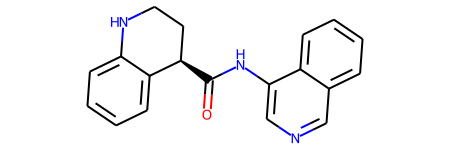

In [11]:
core_smi = "O=C(Nc1cncc2ccccc12)[C@@H]1CCNc2ccccc21" # COVID Moonshot molecule
core_obj = Chem.MolFromSmiles(core_smi)
core_obj

# MUTATE

Generate molecules by replacement of fragments in the supplied molecule with fragments from DB. Seems like you can define the atom ids to be replaced using 'replace_ids' or leave it blank and see any possible mutations.

See https://crem.readthedocs.io/en/latest/operations.html for arguments

Define the atom ids

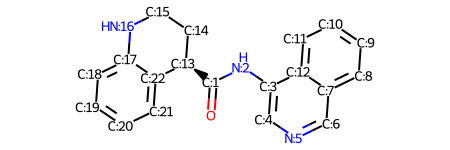

In [3]:
core_obj_1 = core_obj
mol_with_atom_index(core_obj_1)

In [4]:
substructure = Chem.MolFromSmiles('C12=CN=CC=C1C=CC=C2')
sub_matches = core_obj_1.GetSubstructMatches(substructure)
print(sub_matches)

((7, 6, 5, 4, 3, 12, 11, 10, 9, 8),)


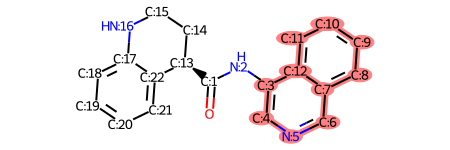

In [5]:
core_obj_1

In [6]:
sub_matches[0]

(7, 6, 5, 4, 3, 12, 11, 10, 9, 8)

## Replace a defined portion

Doesn't seem to work at the moment

In [7]:
mutate_list = list(mutate_mol(core_obj, db_name=crem_db_file, max_size=9, replace_ids=sub_matches[0]))

print('Number of generated molecules:',len(mutate_list))

df_mutated = pd.DataFrame({'smiles': mutate_list})

grid = mols2grid.MolGrid(df_mutated, smiles_col="smiles", size=(225, 250), name="something")
grid.display(subset=["smiles","img"], n_cols=4)

Number of generated molecules: 0


## Replace any hydrogen

Can be used to randomly derivatize a core

In [12]:
mutate_list_H = list(mutate_mol(Chem.AddHs(core_obj), db_name=crem_db_file, max_size=1))

print('Number of generated molecules with H mutation:',len(mutate_list_H))

df_mutated_H = pd.DataFrame({'smiles': mutate_list_H})

grid = mols2grid.MolGrid(df_mutated_H, smiles_col="smiles", size=(225, 250), name="something")
grid.display(subset=["smiles","img"], n_cols=4)

RDKit WARNING: [07:59:25] WARNING: not removing hydrogen atom with dummy atom neighbors
RDKit WARNING: [07:59:26] WARNING: not removing hydrogen atom with dummy atom neighbors
RDKit WARNING: [07:59:26] WARNING: not removing hydrogen atom with dummy atom neighbors
RDKit WARNING: [07:59:26] WARNING: not removing hydrogen atom with dummy atom neighbors
RDKit WARNING: [07:59:26] WARNING: not removing hydrogen atom with dummy atom neighbors
RDKit WARNING: [07:59:26] WARNING: not removing hydrogen atom with dummy atom neighbors
RDKit WARNING: [07:59:26] WARNING: not removing hydrogen atom with dummy atom neighbors
RDKit WARNING: [07:59:26] WARNING: not removing hydrogen atom with dummy atom neighbors
RDKit WARNING: [07:59:26] WARNING: not removing hydrogen atom with dummy atom neighbors
RDKit WARNING: [07:59:26] WARNING: not removing hydrogen atom with dummy atom neighbors
RDKit WARNING: [07:59:26] WARNING: not removing hydrogen atom with dummy atom neighbors
RDKit WARNING: [07:59:26] WARNIN

Number of generated molecules with H mutation: 142


RDKit WARNING: [07:59:26] WARNING: not removing hydrogen atom with dummy atom neighbors


# GROW

GROW replaces a specific hydrogen atom with another fragment

Define where to grow using a SMARTS pattern

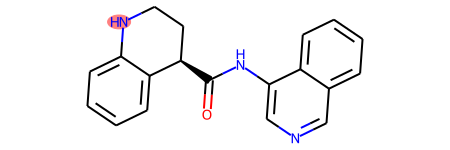

In [13]:
growing_vectors = get_matching_atoms(core_obj,"[NX3;H2,H1;!$(NC=O)]")
core_obj

See https://crem.readthedocs.io/en/latest/operations.html for arguments

Large effect observed changing the radius, for the example molecule radius = 2 gave 321 molecules and radius = 3 gave 22 molecules

In [27]:
grow_list = list(grow_mol(core_obj, db_name=crem_db_file, max_atoms=100, radius = 2, replace_ids=growing_vectors,return_mol=True))
print('Number of generated molecules:',len(grow_list))

grow_smi = []
grow_obj = []
for i in grow_list:  
    grow_smi.append(i[0])
    grow_obj.append(i[1])

RDKit WARNING: [08:03:51] WARNING: not removing hydrogen atom with dummy atom neighbors


Number of generated molecules: 321


In [25]:
df_grown = pd.DataFrame({'rdkit_mols': grow_obj,'smiles': grow_smi})

grid = mols2grid.MolGrid(df_grown, smiles_col="smiles", size=(225, 250), name="something")
grid.display(subset=["smiles","img"], n_cols=4)

# LINK

Link the core to a user-defined fragment with a linker from the database.

First, define where to link the fragment to the core using a SMARTS pattern

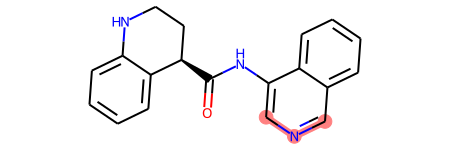

In [35]:
linking_vectors = get_matching_atoms(core_obj,"cn")
core_obj

Define the fragment to be linked and search for results with different dists

See https://crem.readthedocs.io/en/latest/operations.html for arguments

"dist" = topological distance between m1 and m2

radius = lower value means less picky, worth testing from 1 to 3

In [50]:
m1 = core_obj
m2 = Chem.MolFromSmiles('c1ccccc1') # fragment to attach to core

dists_results = []
for i in range(1,11):
    link_list = list(link_mols(m1, m2, db_name=crem_db_file, dist=i, radius=2,replace_ids_1=linking_vectors, replace_ids_2=None, return_mol=True))
    dists_results.append(len(link_list))

print('Generated molecules for dists from 1-10:',dists_results)

RDKit WARNING: [08:15:23] WARNING: not removing hydrogen atom with dummy atom neighbors
RDKit WARNING: [08:15:23] WARNING: not removing hydrogen atom with dummy atom neighbors
RDKit WARNING: [08:15:23] WARNING: not removing hydrogen atom with dummy atom neighbors
RDKit WARNING: [08:15:23] WARNING: not removing hydrogen atom with dummy atom neighbors
RDKit WARNING: [08:15:23] WARNING: not removing hydrogen atom with dummy atom neighbors
RDKit WARNING: [08:15:23] WARNING: not removing hydrogen atom with dummy atom neighbors
RDKit WARNING: [08:15:23] WARNING: not removing hydrogen atom with dummy atom neighbors
RDKit WARNING: [08:15:23] WARNING: not removing hydrogen atom with dummy atom neighbors
RDKit WARNING: [08:15:23] WARNING: not removing hydrogen atom with dummy atom neighbors
RDKit WARNING: [08:15:23] WARNING: not removing hydrogen atom with dummy atom neighbors
RDKit WARNING: [08:15:23] WARNING: not removing hydrogen atom with dummy atom neighbors
RDKit WARNING: [08:15:23] WARNIN

Generated molecules for dists from 1-10: [0, 11, 13, 0, 0, 0, 0, 0, 0, 0]


RDKit WARNING: [08:15:23] WARNING: not removing hydrogen atom with dummy atom neighbors
RDKit WARNING: [08:15:23] WARNING: not removing hydrogen atom with dummy atom neighbors
RDKit WARNING: [08:15:23] WARNING: not removing hydrogen atom with dummy atom neighbors
RDKit WARNING: [08:15:23] WARNING: not removing hydrogen atom with dummy atom neighbors
RDKit WARNING: [08:15:24] WARNING: not removing hydrogen atom with dummy atom neighbors
RDKit WARNING: [08:15:24] WARNING: not removing hydrogen atom with dummy atom neighbors
RDKit WARNING: [08:15:24] WARNING: not removing hydrogen atom with dummy atom neighbors
RDKit WARNING: [08:15:24] WARNING: not removing hydrogen atom with dummy atom neighbors


Results with a specific dist

In [45]:
m1 = core_obj
m2 = Chem.MolFromSmiles('c1ccccc1') # fragment to attach to core

link_list = list(link_mols(m1, m2, db_name=crem_db_file, dist=2, radius=2, replace_ids_1=linking_vectors, replace_ids_2=None, return_mol=True))
print('Number of generated molecules:',len(link_list))

link_smi = []
link_obj = []
for i in link_list:  
    link_smi.append(i[0])
    link_obj.append(i[1])

Number of generated molecules: 11


RDKit WARNING: [08:14:48] WARNING: not removing hydrogen atom with dummy atom neighbors
RDKit WARNING: [08:14:48] WARNING: not removing hydrogen atom with dummy atom neighbors
RDKit WARNING: [08:14:48] WARNING: not removing hydrogen atom with dummy atom neighbors
RDKit WARNING: [08:14:48] WARNING: not removing hydrogen atom with dummy atom neighbors


In [46]:
df_linked = pd.DataFrame({'rdkit_mols': link_obj,'smiles': link_smi})

grid = mols2grid.MolGrid(df_linked, smiles_col="smiles", size=(225, 250), name="something")
grid.display(subset=["smiles","img"], n_cols=4)